# A

In [1]:
#!/usr/bin/env python

# coding: utf-8

# %% Loading Packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
# from sklearn.metrics import mean_squared_error, mean_absolute_erIPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')ror

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.activations import tanh
from tensorflow.keras.layers import PReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import MSE, MAE, MAPE
from tensorflow.keras.metrics import Accuracy, SparseCategoricalAccuracy
from tensorflow.keras.losses import kullback_leibler_divergence, SparseCategoricalCrossentropy, KLDivergence
from tensorflow.keras.callbacks import LearningRateScheduler

import sys

from tensorflow.python.ops.gen_batch_ops import batch

import sys
import os
import sys
import platform

from tensorflow.python.ops.gen_math_ops import Tanh
if platform.node() in ['msbq', 'msdai']:
    os.chdir('/home/ms/github/fxpred')
    sys.path.append(os.path.join(os.getcwd(), 'Transformer'))
from utils import get_fx_and_metric_data_wo_weekend, mde
from utils_NN_opt_learning_rate import opt_learn_rate_plot
from benchmark_utils import actual_pred_plot, ts_train_test_normalize
from transformer_architecture_elements import Time2Vector, SingleAttention, MultiAttention, TransformerEncoder

/home/ms/github/venv/fxpred3/lib/python3.8/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [2]:
dtype = np.float32  # np.float64
df = get_fx_and_metric_data_wo_weekend(dtype=dtype)
target = 'GBPUSD BGNE Curncy Bid Close'
target_column = list(df.columns).index(target)

df_close = get_fx_and_metric_data_wo_weekend(dtype=dtype, pct_change=False)
df = df.iloc[:, target_column : target_column + 1]

nn_type_classification = False
lag=128
h=1

In [3]:
def strategy(x):
    conditions = [
        (x <= -0.00000001),
        (x > -0.00000001) & (x <= 0.00000001),
        (x > 0.00000001)
    ]

    # create a list of the values we want to assign for each condition #!!! 
    values = ['sell', 'hold', 'buy']
    values = [0, 1, 2]

    # create a new column and use np.select to assign values to it using our lists as arguments #!!! 
    return np.select(conditions, values).astype(np.int32)
df['strategy'] = strategy(df[target])

df.head()

,GBPUSD BGNE Curncy Bid Close,strategy
Dates,,
2020-11-01 19:10:00,0.000000,1
2020-11-01 19:20:00,-0.002649,0
2020-11-01 19:30:00,0.000875,2
2020-11-01 19:40:00,0.000132,2
2020-11-01 19:50:00,-0.000023,0


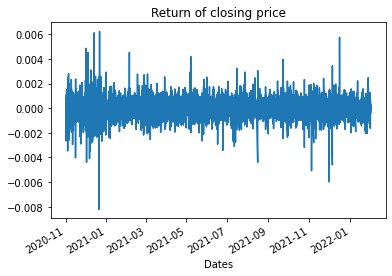

In [4]:
df[target].plot()
plt.title('Return of closing price')
plt.show()

In [5]:
X_train, y_train, X_val, y_val , X_test, y_test, sc, sc_target, index_train, index_val, index_test, X_train_index, y_train_index = \
    ts_train_test_normalize(df, lag, h, 1)

In [6]:
X_train = sc.inverse_transform(X_train)
X_val = sc.inverse_transform(X_val)
X_test = sc.inverse_transform(X_test)
y_train = sc_target.inverse_transform(y_train)
y_val = sc_target.inverse_transform(y_val)
y_test = sc_target.inverse_transform(y_test)

In [7]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import yule_walker

#from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import pmdarima as pmd
# see https://www.pluralsight.com/guides/advanced-time-series-modeling-(arima)-models-in-python
arima = pmd.auto_arima(
    X_train[:, -1, 0],
    d=0,
    start_p=1,
    max_p=20,
    start_q=0,
    max_q=20,
    start_P=0,
    start_Q=0,
    max_P=3,
    max_Q=3,
    test='adf',
    trace=True
)
arima

Performing stepwise search to minimize aic
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-494159.655, Time=6.46 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-494141.387, Time=4.84 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-494160.770, Time=6.74 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-494142.839, Time=1.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-494179.364, Time=18.42 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-494183.607, Time=24.88 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-494184.766, Time=8.57 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-494183.768, Time=10.80 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-494181.758, Time=12.49 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-494186.160, Time=2.96 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-494161.082, Time=1.48 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-494185.156, Time=4.40 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-494185.028, Time=3.71 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-494180.691, T

ARIMA(order=(2, 0, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [8]:
mod = sm.tsa.arima.ARIMA(
    X_train[:, -1, 0],
    order=arima.get_params()['order'],
    seasonal_order=arima.get_params()['seasonal_order']
)
model_train = mod.fit()

/home/ms/github/venv/fxpred3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [9]:
mod_val = sm.tsa.arima.ARIMA(
    X_val[:, -1, 0],
    order=arima.get_params()['order'],
    seasonal_order=arima.get_params()['seasonal_order']
)
mod_test = sm.tsa.arima.ARIMA(
    X_test[:, -1, 0],
    order=arima.get_params()['order'],
    seasonal_order=arima.get_params()['seasonal_order']
)

In [10]:
with mod_val.fix_params(dict(zip(model_train.param_names, model_train.params))):
    model_val = mod_val.fit()
with mod_test.fix_params(dict(zip(model_train.param_names, model_train.params))):
    model_test = mod_test.fit()
model_test.predict().reshape([-1,1])
# predict_data(X_train)

array([[ 1.54102448e-06],
       [-8.41853854e-06],
       [-4.27054779e-06],
       ...,
       [ 9.74803145e-06],
       [ 1.07793490e-05],
       [ 1.68317349e-06]])

In [11]:
def predictions(data_type):
    if data_type == 'train':
        return model_train.predict().reshape([-1,1])
    elif data_type == 'val':
        return model_val.predict().reshape([-1,1])
    elif data_type == 'test':
        return model_test.predict().reshape([-1,1])
    else:
        raise ValueError()

## Econmetric measures

Definition of cumulated returns

In [12]:
def cumulated_return(y_pred, ret, start_capital=1000, dtype=None):
    assert y_pred.flatten().shape == ret.flatten().shape
    balance = [start_capital]
    signal = 0
    for i, d in enumerate(y_pred[:-1]):
        signal = signal if d == 1 else d
        if signal == 0:
            balance.append(balance[-1])
        elif signal == 2:
            balance.append(balance[-1] * ret[i])
        else:
            raise ValueError()
    balance = np.array(balance, dtype=dtype)
    return balance

## read in data for econmic metric

In [13]:
def econ_metrics(y_pred, X_ret, risk_free=0.0031):  # Risk free rate must be given
    x = cumulated_return(y_pred[:-1], X_ret[1:], dtype=dtype)
    print(f'Portfolio return: {x[-1] / x[0] - 1}')
    print(f'Std of returns: {np.std(x[1:] / x[:-1])}')
    print(f'Sharpe ratio: {((x[-1] / x[0]) - 1 - risk_free) / np.std(x[1:] / x[:-1])}')
    print()
    
    n = 6 * 24 * 252  # banking days per year
    mu_annum = ((x[-1]/x[0]) ** (n / x.shape[0])) - 1
    print(f'Return per annum: {mu_annum}')
    std_annum = np.std(x[1:] / x[:-1]) * (n)**0.5
    print(f'Std of returns per annum: {std_annum}')
    print(f'Sharpe ratio per annum: {(mu_annum - risk_free) / std_annum}')

In [14]:
def investment_lengths(y):
    count_length = {0: [], 1: [], 2: []}
    length = 0
    current = y.flatten()[0]
    for i, t in enumerate(y.flatten()):
        if t == current:
            length += 1
        else:
            count_length[current].append(length)
            current = t
            length = 1
    return count_length
def investment_lengths_buy_sell(y):
    count_length = {0: [], 2: []}
    length = 0
    current = y.flatten()[0]
    for i, t in enumerate(y.flatten()):
        if t == current or t == 1:
            length += 1
        else:
            count_length[current].append(length)
            current = t
            length = 1
    return count_length
def changed_number_of_investments(v):
    return sum([len(v) for k, v in count_length.items()])
def investment_length_stats(v, dec_point=4):
    return {k: {'number': len(v), 'mean': np.mean(v).round(dec_point), 'std': np.std(v).round(dec_point), 'max': np.max(v)} for k, v in v.items() if v}

In [15]:
def result_output2(tmp_type):
    print(tmp_type)

    y = eval(f"y_{tmp_type}")
    y_pred = strategy(predictions(tmp_type))
    print(f'Accuracy: {Accuracy()(y.flatten(), y_pred.flatten()).numpy()}')
    print(f'Accuracy: {SparseCategoricalAccuracy()(y.astype(dtype), y_pred.reshape(y.shape).astype(dtype)).numpy()}')
    print(f'KL_Divergence: {kullback_leibler_divergence(y.flatten().astype(dtype), y_pred.flatten().astype(dtype)).numpy()}')
    print(classification_report(y, y_pred))
    cm = confusion_matrix(y, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.show()

#     X_ret = sc.inverse_transform(eval(f"X_{tmp_type}"))[:, -1, 0] + 1
    X_ret = eval(f"X_{tmp_type}")[:, -1, 0] + 1
    plt.plot(eval(f"index_{tmp_type}")[lag-1:-(h+1)][1:], cumulated_return(y_pred[:-1], X_ret[1:], dtype=dtype), label='predicted')

    p = [i[1]/y.shape[0] for i in sorted(Counter(y.flatten()).items(), key=lambda x: x[0])]
    x = np.concatenate(
        [
            cumulated_return(
                np.random.choice([0, 1, 2], size=y_pred[:-1].shape, p=p),
                X_ret[1:],
                dtype=dtype
            )[:,np.newaxis] for i in range(50)
        ], axis=-1
    )
    plt.plot(eval(f"index_{tmp_type}")[(lag-1):-(h+1)][1:], x.mean(axis=-1), label='random', color='gray')
    plt.plot(eval(f"index_{tmp_type}")[(lag-1):-(h+1)][1:], x.mean(axis=-1) + x.std(axis=-1), label='random_q75', color='gray', linestyle='--')
    plt.plot(eval(f"index_{tmp_type}")[(lag-1):-(h+1)][1:], cumulated_return(y_pred[:-1] * 0 + 2, X_ret[1:], dtype=dtype), label='buy&HODL')
    plt.plot(eval(f"index_{tmp_type}")[(lag-1):-(h+1)][1:], cumulated_return(y[:-1], X_ret[1:], dtype=dtype), label='oracle')
    plt.legend()
    plt.semilogy()
    plt.show()
    econ_metrics(y_pred, X_ret)
    print('=============================')
    print('Investment lengths')
    print('y_true')
    print(pd.DataFrame.from_dict(investment_length_stats(investment_lengths(y)), orient='index'))
    print('y_pred')
    print(pd.DataFrame.from_dict(investment_length_stats(investment_lengths(y_pred)), orient='index'))
    print('Investment lengths for only buy and sell (hold is prolongation of previous)')
    print('y_true')
    print(pd.DataFrame.from_dict(investment_length_stats(investment_lengths_buy_sell(y)), orient='index'))
    print('y_pred')
    print(pd.DataFrame.from_dict(investment_length_stats(investment_lengths_buy_sell(y_pred)), orient='index'))

train
Accuracy: 0.48894572257995605
Accuracy: 0.48011261224746704
KL_Divergence: 134424.890625
              precision    recall  f1-score   support

         0.0       0.49      0.44      0.46     18589
         1.0       0.05      0.00      0.00      1222
         2.0       0.49      0.57      0.53     18907

    accuracy                           0.49     38718
   macro avg       0.34      0.34      0.33     38718
weighted avg       0.48      0.49      0.48     38718



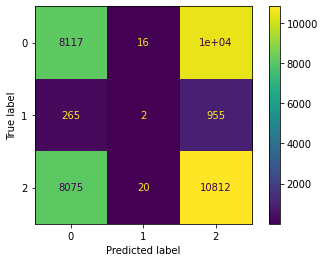

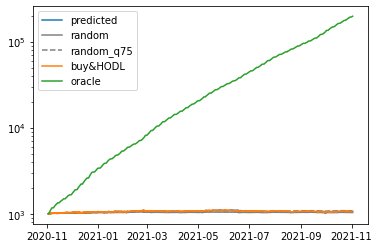

Portfolio return: 0.06010758876800537
Std of returns: 0.00030994880944490433
Sharpe ratio: 183.92581946064513

Return per annum: 0.05623257284132932
Std of returns per annum: 0.059043417764527054
Sharpe ratio per annum: 0.8998898582265179
Investment lengths
y_true
   number    mean     std  max
0    9864  1.8845  1.2695   13
1     616  1.9838  7.5889  154
2    9830  1.9233  1.2918   12
y_pred
   number    mean     std  max
0    6522  2.5227  1.7558   16
1      38  1.0000  0.0000    1
2    6527  3.4048  3.5271  162
Investment lengths for only buy and sell (hold is prolongation of previous)
y_true
   number    mean     std  max
0    9690  2.0057  2.4379  161
2    9689  1.9901  1.3767   15
y_pred
   number    mean     std  max
0    6517  2.5277  1.7587   16
2    6518  3.4122  3.5332  162


In [16]:
result_output2('train')

In [17]:
# result_output2('val')

test
Accuracy: 0.4839187562465668
Accuracy: 0.4807448089122772
KL_Divergence: 16682.2265625
              precision    recall  f1-score   support

         0.0       0.49      0.43      0.46      2272
         1.0       0.00      0.00      0.00       156
         2.0       0.48      0.57      0.52      2298

    accuracy                           0.48      4726
   macro avg       0.32      0.33      0.33      4726
weighted avg       0.47      0.48      0.47      4726



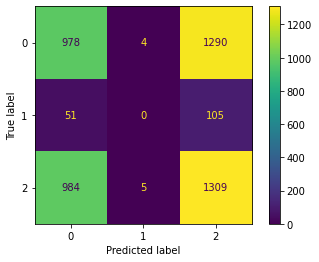

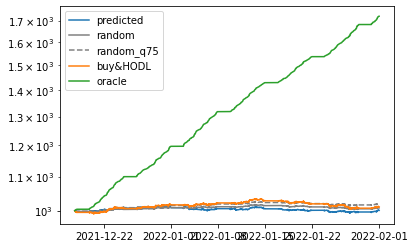

Portfolio return: 0.0011376142501831055
Std of returns: 0.00025015920982696116
Sharpe ratio: -7.844547283205387

Return per annum: 0.008770145954500874
Std of returns per annum: 0.04765385213096864
Sharpe ratio per annum: 0.11898609872959327
Investment lengths
y_true
   number    mean     std  max
0    1237  1.8367  1.2160   10
1     108  1.4444  1.2644    6
2    1233  1.8621  1.2218   11
y_pred
   number    mean     std  max
0     816  2.4669  1.7254   16
1       9  1.0000  0.0000    1
2     820  3.2841  2.4666   15
Investment lengths for only buy and sell (hold is prolongation of previous)
y_true
   number    mean     std  max
0    1207  1.9519  1.3939   12
2    1206  1.9635  1.3197   11
y_pred
   number    mean     std  max
0     816  2.4694  1.7240   16
2     816  3.3088  2.5103   17


In [18]:
result_output2('test')